# Sprint 機械学習スクラッチ 決定木

分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


決定木の学習には何回まで条件分岐を繰り返すかを表す （最大の）深さ というハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。


学習の仕方には様々な方法がありますが、ここではscikit-learnでも使用されている CART法 をベースとした実装を行います。この方法では学習の複雑さを減らすために、 分岐は2つに分かれるのみ になります。


以下に雛形を用意してあります。このScratchDecesionTreeClassifierDepth1クラスにコードを書き加えていってください。

## 雛形

In [35]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        pass
        return

## 【問題1】不純度を求める関数

ノード の ジニ不純度 を計算する関数を作成してください。ノード 
t
 に対するジニ不純度 
I
(
t
)
 は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。

$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$

t
 : ノードのインデックス


i
 : クラスのインデックス


K
 : クラスの数


C
i
 : i番目のクラス


P
(
C
i
|
t
)
 :　t番目のノードにおける
C
i
の割合


N
t
,
i
 : t番目のノードのi番目のクラスに属するサンプル数


N
t
,
a
l
l
 : t番目のノードのサンプルの総数


まずは簡単な例を作り、手計算と関数の結果を比較してください。

In [5]:
def gain_gini(y):
    
    # pureの初期化
    pure = 0
    # yの固有値リストの分だけpureを算出、合算
    for y_set in list(set(y)):
        pure += ((y==y_set).sum()/y.shape[0])**2
    gini = 1 - pure
    
    return gini

In [10]:
import numpy as np
from sklearn.datasets import load_iris
# データセットのロード
iris = load_iris()
X = iris.data[:,[0,1]][:100]
y = iris.target[:100]

In [11]:
gain_gini(y)

0.5

In [12]:
# クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
y_t0 = np.zeros(15)
y_t1 = np.ones(15)
y_t0_t1 = np.concatenate([ y_t0, y_t1])
gain_gini(y_t0_t1)

0.5

In [13]:
# クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
y_t0 = np.zeros(15)
y_t1 = np.ones(15)
y_t2 = np.full(15,2)
y_t0_t1_t2 = np.concatenate([ y_t0, y_t1, y_t2])
gain_gini(y_t0_t1_t2)

0.6666666666666667

In [14]:
# クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
y_t0 = np.zeros(18)
y_t1 = np.ones(12)
y_t0_t1 = np.concatenate([ y_t0, y_t1])
gain_gini(y_t0_t1)

0.48

In [15]:
# クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000
y_t0 = np.zeros(30)
gain_gini(y_t0)

0.0

## 【問題2】情報利得を求める関数

次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 
I
(
t
)
 を計算する関数を呼び出して使います。情報利得
I
G
は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。


ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。

$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$

In [86]:
def gain_ig( root_gini, left_gini, right_gini, root_len):
    '''
    情報利得を計算する
    '''
    #割合
    left_ratio = len(left)/root_len
    right_ratio = len(right)/root_len
    
    return root_gini - left_gini*left_ratio- right_gini*right_ratio

In [87]:
left_c1 = np.full(10, 1)
left_c2 = np.full(30, 2)
right_c1 = np.full(20, 1)
right_c2 = np.full(5, 2)
left = np.concatenate([left_c1, left_c2])
right = np.concatenate([right_c1, right_c2])
parent = np.concatenate([left, right])

root_gini = gain_gini(parent)
left_gini = gain_gini(left)
right_gini = gain_gini(right)
root_len = len(parent)

gain_ig(root_gini, left_gini, right_gini, root_len)

0.14319526627218937

## 【問題3】学習

空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。


訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。


クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。

In [ ]:
    def fit(self, X, y):
        
        # 不純度の計算
        root_gini = gain_gini(y)
        
        # 初期化
        ig_max = 0
        
        for j in range(X.shape[1]): 
            # Xの固有値リストを取得
            X_set = list(set(X[:, j]))
            
            for i in range(len(X_set)-1):
                # Xの固有値を元に分割
                # 各node保持
                self.y_left = y[np.where(X[:, j]<=X_set[i])]
                self.y_right = y[np.where(X[:, j]>X_set[i])]
                
                # 不純度の計算
                left_gini = gain_gini(self.y_left)
                right_gini = gain_gini(self.y_right)
                
                # 利得の計算
                root_len = len(y)
                ig = gain_ig(self, root_gini, left_gini, right_gini, root_len)
                
                # 利得が最大となる組み合わせの保持
                if ig > ig_max:
                    ig_max = ig
                    self.best_class_left = np.unique(self.y_left,
                                                     return_counts=True)[1].argmax()
                    self.best_class_right = np.unique(self.y_right,
                                                      return_counts=True)[1].argmax()
                    self.best_X_set = X_set[i]
                    self.best_col = j
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()

## 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。


入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

In [ ]:
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        y_pred = np.zeros(X.shape[0])
        y_pred[np.where(X[:, self.best_col]<=self.best_X_set)] = self.best_class_left
        y_pred[np.where(X[:, self.best_col]>self.best_X_set)] = self.best_class_right
        
        return y_pred

### 問題1〜4を反映したコード

In [27]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        # 各ノードのインスタンス
        self.y_left = 0
        self.y_right = 0
        # 最適なXの分割ポイント
        self.best_X_set = 0
        self.best_col = 0
        self.best_class_left = 0
        self.best_class_right = 0
        
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        """
        #rootの不純度の計算
        root_gini = gain_gini(y)
        
        # 最大利得の初期化
        ig_max = 0
        
        # 最も不純度が低下する組み合わせを網羅的に探索
        # 特徴量毎に繰り返す
        for j in range(X.shape[1]): 
            # Xの固有値リストを取得（setでソート済み）
            X_set = list(set(X[:, j]))
            
            # 「Xの固有値の数−１」for
            for i in range(len(X_set)-1):
                # Xの固有値を元に分割
                # 各node保持
                self.y_left = y[np.where(X[:, j]<=X_set[i])]
                self.y_right = y[np.where(X[:, j]>X_set[i])]
                
                # 不純度の計算
                left_gini = gain_gini(self.y_left)
                right_gini = gain_gini(self.y_right)
                
                # 利得の計算
                root_len = len(y)
                ig = gain_ig(self, root_gini, left_gini, right_gini, root_len)
                
                # 利得が最大となる組み合わせの保持
                if ig > ig_max:
                    ig_max = ig
                    self.best_class_left = np.unique(self.y_left,
                                                     return_counts=True)[1].argmax()
                    self.best_class_right = np.unique(self.y_right,
                                                      return_counts=True)[1].argmax()
                    self.best_X_set = X_set[i]
                    self.best_col = j
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
            
            
    def gain_gini(y):
        
        # pureの初期化
        pure = 0
        # yの固有値リストの分だけpureを算出、合算
        for y_set in list(set(y)):
            pure += ((y==y_set).sum()/y.shape[0])**2
        gini = 1 - pure
    
        return gini

    def gain_ig(self, root_gini, left_gini, right_gini, root_len):
        '''
        情報利得を計算する
        '''
        #割合
        left_ratio = len(self.y_left)/root_len
        right_ratio = len(self.y_right)/root_len
    
        return root_gini - left_gini*left_ratio- right_gini*right_ratio
    
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        y_pred = np.zeros(X.shape[0])
        y_pred[np.where(X[:, self.best_col]<=self.best_X_set)] = self.best_class_left
        y_pred[np.where(X[:, self.best_col]>self.best_X_set)] = self.best_class_right
        
        return y_pred

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [47]:
# シンプルデータセット２
X2 = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [41]:
# 評価指標の関数
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def evalate(y_test, y_pred):
    print("accuracy =", accuracy_score(y_test, y_pred))
    print("precision =", precision_score(y_test, y_pred, average='macro'))
    print("recall =", recall_score(y_test, y_pred, average='macro'))
    print("f1 =", f1_score(y_test, y_pred, average='macro'))

In [60]:
#スクラッチによる学習、推定
scratchtree = ScratchDecesionTreeClassifierDepth1()
scratchtree.fit(X2, y2)
y_pred =scratchtree.predict(X2)
evalate(y2, y_pred)

accuracy = 0.675
precision = 0.719435736677116
recall = 0.675
f1 = 0.6576695194206715


In [63]:
#scikit-learnによる学習、推定
from sklearn.tree import DecisionTreeClassifier
sktree = DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=0)
sktree.fit(X2, y2)
y_pred2 =scratchtree.predict(X2)
evalate(y2, y_pred2)

accuracy = 0.675
precision = 0.719435736677116
recall = 0.675
f1 = 0.6576695194206715


## 【問題6】決定領域の可視化
決定領域を可視化してください。

In [64]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [65]:
def decision_region(X_train, y_train, model, step=0.01, title='decision region',
                    xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples, 1)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X_train[:, 0])-0.5, np.max(X_train[:, 0])+0.5, step),
                                   np.arange(np.min(X_train[:, 1])-0.5, np.max(X_train[:, 1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1,
                 cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1,
                colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train == target][:, 0], X_train[y_train == target]
                    [:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i],
                              label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

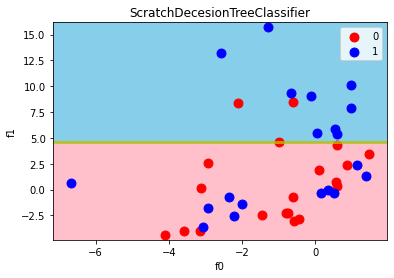

In [68]:
# スクラッチによる決定領域
decision_region(X2, y2, scratchtree, title='ScratchDecesionTreeClassifier', xlabel='f0', ylabel='f1', target_names=['0', '1'])

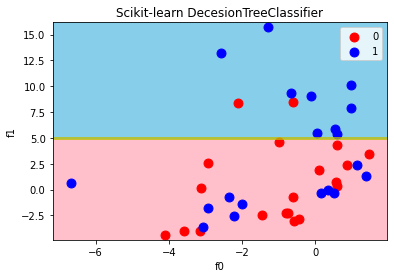

In [70]:
#scikit-learnによる決定領域
decision_region(X2, y2, sktree, title='Scikit-learn DecesionTreeClassifier', xlabel='f0', ylabel='f1', target_names=['0', '1'])